# Feature Analysis

In [1]:
import pandas as pd
import math

In [2]:
filenames1 = ['pionminus','pionminus1','pionminus2','pionminus3','pionminus4','pionminus5']
filename2 = 'newDB'#'electron1'
filepath = "/home/yoren/bnl/PHENIX/ee/ML/"
hadron_weight = 10000*50/500

In [3]:
if False:
    data1 = pd.read_csv(filepath+f'{filenames1[0]}.csv')
    data1.loc[data1['phi0'] > -99, 'phi0'] = 0
    for ifile in range(1,len(filenames1)):
        idata = pd.read_csv(filepath+f'{filenames1[ifile]}.csv')
        idata.loc[idata['phi0'] > -99, 'phi0'] = 0
        data1 = pd.concat([data1,idata], sort=False)
    data1 = pd.concat([data1,data1], sort=False)
    data1 = pd.concat([data1,data1], sort=False)
    data1 = pd.concat([data1,data1], sort=False)
    data1 = pd.concat([data1,data1], sort=False)

    data = pd.concat([data1,data2], sort=False)
    data = data.sample(frac = 1)
    data['phi0'] = data['phi0'].astype('int32')
    data['centrality'] = data['centrality'].astype('int32')
    data['zvertex'] = data['zvertex'].astype('float16')
    data['pt'] = data['pt'].astype('float16')
    data['e/p'] = data['e/p'].astype('float16')
    data['n0'] = data['n0'].astype('int32')
    data['disp'] = data['disp'].astype('float16')
    data['chi2'] = data['chi2'].astype('float16')
    data['npe0'] = data['npe0'].astype('int32')
    data['prob'] = data['prob'].astype('float16')
    data.head()
    
    data['disp2'] = data.apply(lambda row: row['disp']**2, axis=1)
    data['n0*disp'] = data.apply(lambda row: (row['n0']-2)/(1+row['disp']), axis=1)
    data['n0*disp2'] = data.apply(lambda row: (row['n0']-2)/(1+row['disp'])**0.5, axis=1)
    data['chi2/npe0'] = data.apply(lambda row: row['chi2']/(row['npe0']+0.001), axis=1)
    data['e/p*prob'] = data.apply(lambda row:  math.copysign(1,row['e/p']-0.8)*(row['e/p']-0.8)**2*(row['prob']), axis=1)
    data['n0*prob'] = data.apply(lambda row: (row['n0']-2)*(row['prob']+0.001), axis=1)
    data['prob-1'] = data.apply(lambda row: 1./(1.00001-row['prob'])**0.5, axis=1)
    data['e/p*pt'] = data.apply(lambda row: ((row['pt'])**0.5)*math.copysign(1,row['e/p']-0.8)*(row['e/p']-0.8)**2, axis=1)
    data['n0*pt'] = data.apply(lambda row: (row['n0']-2)*(row['pt']+0.001)**0.5, axis=1)
    #data['e/p*centrality'] = data.apply(lambda row: row['e/p']*(row['centrality']+0.001)**0.5, axis=1)
    #data['n0*centrality'] = data.apply(lambda row: row['n0']*(row['centrality']+0.001)**0.5, axis=1)
    data['n0-2'] = data.apply(lambda row: (row['n0']-2)*(row['n0']), axis=1)
    data['e/p-0.8'] = data.apply(lambda row: math.copysign(1,row['e/p']-0.8)*(row['e/p']-0.8)**2, axis=1)
    data['pt-1'] = data.apply(lambda row: row['pt']**-1, axis=1)
    data['pt2'] = data.apply(lambda row: row['pt']**2, axis=1)
    data['centrality-2'] = data.apply(lambda row: row['centrality']**-2, axis=1)
    data.head()

In [4]:
data = pd.read_csv(filepath+f'{filename2}.csv')
#data2.loc[data2['phi0'] > -99, 'phi0'] = 1
#data2 = data2[:100000]

In [5]:
print(data.size, data.shape)

261258888 (10885787, 24)


In [6]:
# удалим лишние колонки
data = data.drop(columns = ['zvertex'])

In [7]:
import matplotlib.pyplot as plt

def analysis(data: pd.DataFrame):
    fig, ax = plt.subplots(3, 3, figsize=(15, 6))
    for i, feature in enumerate(['centrality', 'pt', 'e/p', 'n0', 'disp', 'chi2', 'npe0', 'prob', 'phi0']):
        x, y = divmod(i, 3)
        data[feature].plot.hist(ax=ax[x][y], ylabel='', title=feature, color='skyblue', logy=True)


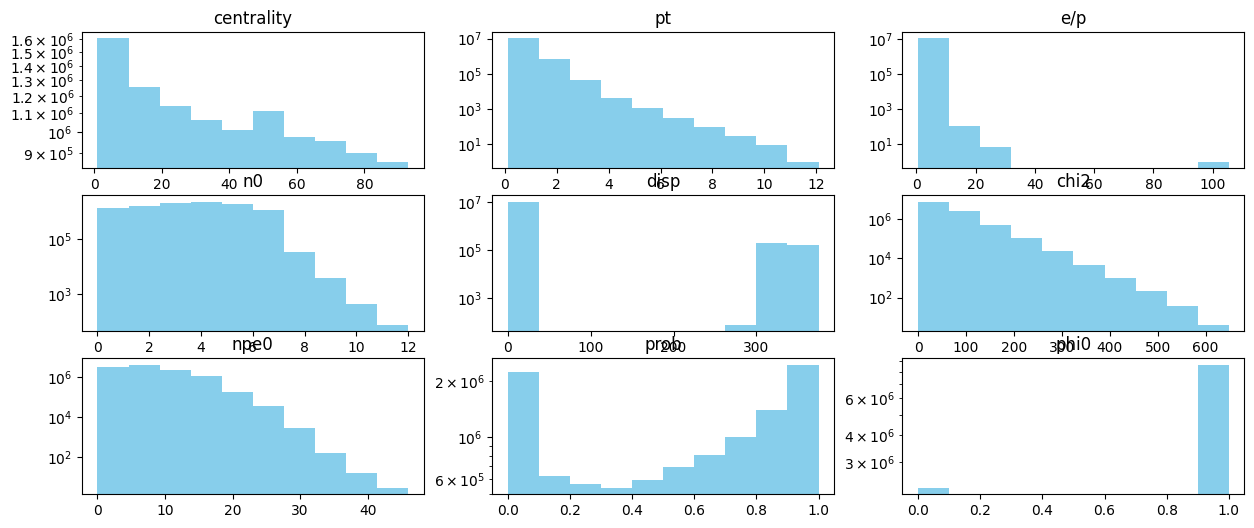

In [8]:
analysis(data)

+ Видим, что impressions имеют только одно значение, поэтому их можно удалить.
+ Таргет-переменная clicks сильно несбалансирована. Возможно, стоит использовать балансировку весов, а также в качестве оценки моделей использовать f1 и ROC AUC.
+ У campaign_clicks нулевых значений сильно больше, чем ненулевых, следовательно, можно трансформировать в бинарную фичу
+ os_id со значениями больше 6 встречается редко, можно объединить в одну категорию
+ Аналогично с редкими значениями zone_id

# Feature Engineering

In [9]:
from sklearn.preprocessing import OneHotEncoder

def feature_engineering(data: pd.DataFrame) -> pd.DataFrame:
    # удаляем impressions
    data = data.drop('impressions', axis = 1)
    
    # создаем фичи от времени
    data.date_time = pd.to_datetime(data.date_time)
    data['day'] = data['date_time'].dt.weekday
    data['hour'] = data['date_time'].dt.hour
    
    # строим графики зависимости количества кликов от дня недели и часа
    data[data['clicks'] > 0].sort_values(by = ['day']).groupby(['day'])['clicks'].sum().plot.barh(title='Clicks by weekday')
    plt.show()
    data[data['clicks'] > 0].sort_values(by = ['hour']).groupby(['hour'])['clicks'].sum().plot.barh(title='Clicks by hour')

    # добавляем интерсекции между часом и днем недели 
    data['hour_day'] = data['day'].astype(str) + ' ' + data['hour'].astype(str)
    data['hour_day'] = pd.factorize(data['hour_day'])[0]
    
    # выделяем редкие zone id в категорию -1
    zone_id_counts = data['zone_id'].value_counts()
    idxs = zone_id_counts[zone_id_counts < 10].index
    
    data.loc[data['zone_id'].isin(idxs), 'zone_id'] = -1
    
    # выделяем редкие os_id в категорию 7
    data.loc[data['os_id'] > 7, 'os_id'] = 7
    
    # преобразовываем campaign clicks в бинарную фичу
    data['before_clicks'] = data['campaign_clicks'] > 0
    data['before_clicks'] = data['before_clicks'].astype('int64')
    
    # делим выборку на train и test
    data = data.sort_values(by='date_time', ignore_index=True)
    cut_off_val = data[data['date_time'] < pd.to_datetime('2021-10-01')].index[-1]
    cut_off_test = data[data['date_time'] < pd.to_datetime('2021-10-02')].index[-1]

    y = data['clicks']
    data = data.drop(columns = ['banner_id', 'clicks', 'campaign_clicks', 'date_time'])
    data_train, data_test = data.iloc[:cut_off_test, :], data.iloc[cut_off_test:, :]
    y_train, y_test = y.iloc[:cut_off_test], y.iloc[cut_off_test:]
    
    # делаем one hot encodings
    enc = OneHotEncoder(drop='first', handle_unknown='ignore')
    enc.fit(data_train)
    transformed_train = enc.transform(data_train)
    transformed_test = enc.transform(data_test)
    
    return transformed_train, transformed_test, y_train, y_test,cut_off_val

In [10]:
def feature_engineering(data: pd.DataFrame) -> pd.DataFrame:
    # делим выборку на train и test
    #data = data.sort_values(by='date_time', ignore_index=True)
    #cut_off_val = data[data['date_time'] < pd.to_datetime('2021-10-01')].index[-1]
    #cut_off_test = data[data['date_time'] < pd.to_datetime('2021-10-02')].index[-1]

    cut_off_val =  int (data.shape[0]/3)
    cut_off_test = int (data.shape[0]/3*2 + 1)

    print(cut_off_val,cut_off_test)

    y = data['phi0']
    data = data.drop(columns = ['phi0'])
    data_train, data_test = data[:cut_off_test], data[cut_off_test:]
    y_train, y_test = y.iloc[:cut_off_test], y.iloc[cut_off_test:]
    
    # делаем one hot encodings
    #enc = OneHotEncoder(drop='first', handle_unknown='ignore')
    #enc.fit(data_train)
    #transformed_train = enc.transform(data_train)
    #transformed_test = enc.transform(data_test)
    
    return data_train, data_test, y_train, y_test,cut_off_val

In [11]:
transformed_train_all, transformed_test, y_train_all, y_test, cut_off_val = feature_engineering(data)

3628595 7257192


In [12]:
transformed_test

,centrality,pt,e/p,n0,disp,chi2,npe0,prob,disp2,n0*disp,...,e/p*prob,n0*prob,prob-1,e/p*pt,n0*pt,n0-2,e/p-0.8,pt-1,pt2,centrality-2
7257192,75,0.3777,0.8013,3,3.875,35.660,9,0.618700,15.015625,0.205128,...,9.970879e-07,0.619652,1.619324,9.904943e-07,0.615374,3.0,0.000002,2.647705,0.142646,0.000178
7257193,42,0.5780,0.8276,3,6.395,101.900,7,0.000994,40.890030,0.135235,...,7.589982e-07,0.001994,1.000492,5.807428e-04,0.761003,3.0,0.000764,1.729730,0.334229,0.000567
7257194,8,0.4836,0.9530,3,5.984,24.220,4,0.159700,35.812744,0.143177,...,3.743777e-03,0.160668,1.090867,1.630626e-02,0.696163,3.0,0.023447,2.067643,0.233910,0.015625
7257195,17,0.5920,0.8220,1,6.457,135.200,1,0.520000,41.693253,-0.134102,...,2.466207e-04,-0.521020,1.443390,3.648347e-04,-0.769933,-1.0,0.000474,1.689769,0.350224,0.003460
7257196,36,0.5107,0.9277,2,4.312,79.440,4,0.944000,18.597656,0.000000,...,1.539988e-02,0.000000,4.219659,1.166048e-02,0.000000,0.0,0.016316,1.957935,0.260858,0.000772
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10885782,70,0.3953,0.9326,2,5.170,83.100,3,0.925000,26.748291,0.000000,...,1.626483e-02,0.000000,3.646496,1.105715e-02,0.000000,0.0,0.017587,2.529957,0.156233,0.000204
10885783,11,0.3435,1.3940,2,3.460,10.350,4,0.002916,11.978088,0.000000,...,1.027446e-03,0.000000,1.001456,2.064850e-01,0.000000,0.0,0.352307,2.911158,0.117996,0.008264
10885784,67,0.8853,0.8496,3,1.307,4.402,3,0.170500,1.707310,0.433531,...,4.196952e-04,0.171532,1.097988,2.315589e-03,0.941411,3.0,0.002461,1.129619,0.783674,0.000223
10885785,67,1.5030,0.9707,3,2.773,47.900,6,0.936500,7.691956,0.265010,...,2.728988e-02,0.937523,3.968799,3.572336e-02,1.226348,3.0,0.029140,0.665367,2.258798,0.000223


In [13]:
transformed_train, transformed_val = transformed_train_all[:cut_off_val], transformed_train_all[cut_off_val:]
y_train, y_val = y_train_all[:cut_off_val], y_train_all[cut_off_val:]
w_train, w_val = y_train-1, y_val-1
w_test = y_test-1
w_train_all = y_train_all - 1
w_train = w_train*(-hadron_weight)+1
w_val = w_val*(-hadron_weight)+1
w_test = w_test*(-hadron_weight)+1
w_train_all = w_train_all*(-hadron_weight)+1

+ Увидели, что количество кликов меняется в зависимости от дня недели и часа, добавим в качестве фичей
+ Также, добавим интеракции между этими двумя переменными, так как в разные дни недели разные часы могут по-разному влиять на колличество кликов
+ banner_id удалила, так как предполагаю, что модель должна уметь предсказывать клики для новых баннеров тоже.
+ Так как все оставшиеся фичи являются категориальными, сделали one-hot-encoding


+ В качестве теста берем последний день датасета, в качестве валидации -- предпоследний

# Create Model

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, log_loss, f1_score

In [ ]:
def create_model(C):
    clf = LogisticRegression(solver='newton-cholesky', max_iter=10000, C=C, verbose=1)
    return clf

Возьмем логистическую регрессию, в качестве солвера берем newton-cholesky, так как в документации sklearn сказано, что он лучше работает с one-hot-encoded фичами.

# Cross Validation

In [16]:
def cv(data_train: pd.DataFrame, data_val, y_train, y_val):
    best_score = 0.5
    best_C = 0.1
    for C in [0.0001,0.001,0.01,0.05,0.1,1,10,100,1000,10000]:
        clf = create_model(C)
        clf.fit(data_train, y_train)
        y_pred_probs = clf.predict_proba(data_val)
        score = roc_auc_score(y_val, y_pred_probs[:, 1])
        if score > best_score:
            best_score = score
            best_C = C
            print("localy best C:", best_C)       
    print("the best C:", best_C)        
    best_model = create_model(best_C)
    return best_model

In [17]:
print(transformed_val.shape,y_val.shape)

(3628597, 22) (3628597,)


In [18]:
clf = cv(transformed_train, transformed_val, y_train, y_val)

Newton iter=1
  Check Convergence
    1. max |gradient| 371.2872378957525 <= 0.0001
Newton iter=2
  Check Convergence
    1. max |gradient| 130.32581481076394 <= 0.0001
Newton iter=3
  Check Convergence
    1. max |gradient| 36.491241111401806 <= 0.0001
Newton iter=4
  Check Convergence
    1. max |gradient| 4.353626302978795 <= 0.0001
Newton iter=5
  Check Convergence
    1. max |gradient| 0.10823506288248096 <= 0.0001
Newton iter=6
  Check Convergence
    1. max |gradient| 0.0004190067776371482 <= 0.0001
Newton iter=7
  Check Convergence
    1. max |gradient| 2.982611899587336e-08 <= 0.0001
    2. Newton decrement 1.6448698859085181e-10 <= 0.0001
  Solver did converge at loss = 0.2571533059099878.
localy best C: 0.0001
Newton iter=1
  Check Convergence
    1. max |gradient| 381.77396000611793 <= 0.0001
Newton iter=2
  Check Convergence
    1. max |gradient| 130.9691643396704 <= 0.0001
Newton iter=3
  Check Convergence
    1. max |gradient| 33.793334248315524 <= 0.0001
Newton iter=4
 

Обучаем лучшую модель заново на тренировочном и валидационном датасете.

In [19]:
clf.fit(transformed_train_all, y_train_all, w_train_all)

Newton iter=1
  Check Convergence
    1. max |gradient| 1834.7020663849894 <= 0.0001
Newton iter=2
  Check Convergence
    1. max |gradient| 641.5177234120289 <= 0.0001
Newton iter=3
  Check Convergence
    1. max |gradient| 232.53309331301617 <= 0.0001
Newton iter=4
  Check Convergence
    1. max |gradient| 85.36718245472095 <= 0.0001
Newton iter=5
  Check Convergence
    1. max |gradient| 32.02120571779723 <= 0.0001
Newton iter=6
  Check Convergence
    1. max |gradient| 12.81860879548157 <= 0.0001
Newton iter=7
  Check Convergence
    1. max |gradient| 6.129278709507678 <= 0.0001
Newton iter=8
  Check Convergence
    1. max |gradient| 3.7953638518461803 <= 0.0001
Newton iter=9
  Check Convergence
    1. max |gradient| 2.058110663128301 <= 0.0001
Newton iter=10
  Check Convergence
    1. max |gradient| 0.5627802234950047 <= 0.0001
Newton iter=11
  Check Convergence
    1. max |gradient| 0.06277388320382889 <= 0.0001
Newton iter=12
  Check Convergence
    1. max |gradient| 0.001014669

LogisticRegression(C=0.1, max_iter=10000, solver='newton-cholesky', verbose=1)

# Model Evaluation

In [20]:
y_pred_probs = clf.predict_proba(transformed_test)
y_pred = clf.predict(transformed_test)

In [21]:
clf

LogisticRegression(C=0.1, max_iter=10000, solver='newton-cholesky', verbose=1)

Посчитаем скоры (ROC AUC, log loss и f1 score).

log loss: 0.015146629227132372
roc auc: 0.9479919449093017
f1 score: 0.9163563084734492


Text(0.5, 1.0, 'ROC AUC Curve')

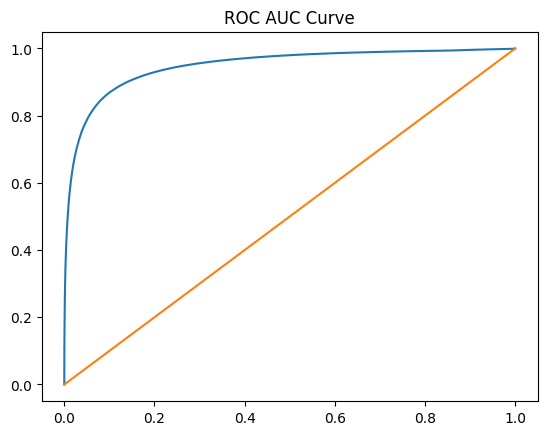

In [22]:
import numpy as np
from sklearn import metrics
from sklearn.metrics import roc_auc_score, log_loss, f1_score

print('log loss:', log_loss(y_test, y_pred_probs, sample_weight=w_test))

fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_probs[:, 1], pos_label=1, sample_weight=w_test)
metrics.auc(fpr, tpr)
print('roc auc:', metrics.auc(fpr, tpr))

optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
y_pred_opt = y_pred_probs[:, 1] > optimal_threshold
print('f1 score:', f1_score(y_test, y_pred_opt))
plt.plot(fpr, tpr)
plt.plot(fpr, fpr)
plt.title('ROC AUC Curve')

Сравним со скорами из бейзлайна. Бейзлайн: предсказываем все нулями

In [23]:
pred_baseline = np.ones_like(y_test) * y_test.mean()
print("baseline auc:", roc_auc_score(y_test, pred_baseline))
print("baseline log_loss:", log_loss(y_test, pred_baseline))

baseline auc: 0.5
baseline log_loss: 0.5108648767426065


Видим, что наша модель обгоняет бейзлайн по метрикам ROC AUC и Log Loss.

In [24]:
i = 16000
print(round(tpr[i],3),round(fpr[i]/tpr[i],4))
print(thresholds[i],fpr[i],tpr[i])
#print((fpr[i]/tpr[i]*data1.shape[0]/data2.shape[0]/10)**-1,(fpr[i]/1.*data1.shape[0]/data2.shape[0]/10)**-1)

0.558 0.0197
0.050956325828253886 0.01097690762252814 0.5581501718427012


In [25]:
print(clf.intercept_)
for keff in clf.coef_[0]:
    print(keff)
output_data = [clf.intercept_,clf.coef_[0]]
with open("output/keffs.txt", "w") as txt_file:
    for line in output_data:
        txt_file.write("".join(str(line)) + "\n")

[-13.02502973]
0.021124853988779804
3.43499376186029
7.027037236392406
-1.1272955627874133
-0.3835469375031524
-0.00877931194243796
0.18718224748569745
2.759658220050528
0.001027898282083359
-5.548518640234574
7.315898911788007
9.683935472005518e-06
-7.5624419134614165
0.02076305005811744
-0.007013118923041002
-5.294528485984675
0.10010915154279658
-0.16888082656875858
-2.795090833934372
0.40493983612140483
-0.7166772319423004
-0.4473267904518569


In [26]:
def answer(input_vars):
    ans = clf.intercept_[0]
    i = 0
    for input_var in input_vars:
        ans += clf.coef_[0][i]*input_var
        i+=1
    return 1./(1.+np.exp(-ans))

In [27]:
kek_data = data
kek_data = kek_data.drop(columns = ['phi0'])
proba_loc = clf.predict_proba(kek_data)
print(proba_loc[0][1])

0.4352022869274979


In [28]:
mycute,mycuth, AIcute, AIcuth = 0, 0, 0, 0
norm_e, norm_h = 0, 0
data0 = data.reset_index()  # make sure indexes pair with number of rows

counter =-1
for index, row in data0.iterrows():
    counter+=1
    if counter>100000: break
    centrality, pt, ep, n0, disp, chi2, npe0, prob, phi0 = row['centrality'], row['pt'], row['e/p'], row['n0'], row['disp'], row['chi2'], row['npe0'], row['prob'], row['phi0']
    if pt<0.4 or centrality<0: continue
    if ep>0.8 and n0>=2+disp**2/8 and prob>0.01 and chi2/(npe0+1e-4)<10: 
        if phi0: mycute+=1
        else: mycuth+=1
    if proba_loc[counter][1]>thresholds[i]: 
        if phi0: AIcute+=1
        else: AIcuth+=1
    if phi0: norm_e+=1
    else: norm_h+=1
    vars_names = list(kek_data.columns)
    input_func = []
    for var_name in vars_names:
        input_func.append(row[var_name])
    if counter<10: 
        print(proba_loc[counter],answer(input_func))
        #print(centrality, pt, ep, n0, disp, chi2, npe0, prob, phi0 )

[0.56479771 0.43520229] 0.4352022869274989
[9.99516132e-01 4.83868049e-04] 0.0004838680489527541
[0.922983 0.077017] 0.07701700158036172
[0.53863557 0.46136443] 0.4613644292119547
[0.99155517 0.00844483] 0.008444832868690503
[0.84790646 0.15209354] 0.1520935356973356
[9.99980740e-01 1.92595336e-05] 1.9259533646832662e-05
[0.42315749 0.57684251] 0.576842506425186
[0.71387455 0.28612545] 0.2861254478265827
[0.98722475 0.01277525] 0.012775250355123101


In [29]:
print(norm_e, norm_h,round(mycute/norm_e,3),round(mycuth/norm_h,3), round(AIcute/norm_e,3), round(AIcuth/norm_h,3), round(AIcuth/AIcute/norm_h*norm_e,3),round(fpr[i]/tpr[i],3))

70884 19712 0.52 0.012 0.575 0.011 0.02 0.02


In [30]:
print(round(AIcute/mycute/(AIcuth/mycuth),3),round(AIcute/mycute,3),round(AIcuth/mycuth,3), round(30*AIcute/norm_e/AIcuth*norm_h))

1.21 1.107 0.915 1513
